In [36]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy import interpolate
import cv2 as cv
import os

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from data import download_all_data

CUR_DIR = os.path.abspath('')

# Dataset


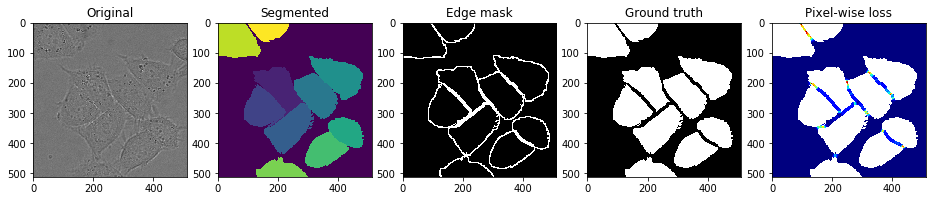

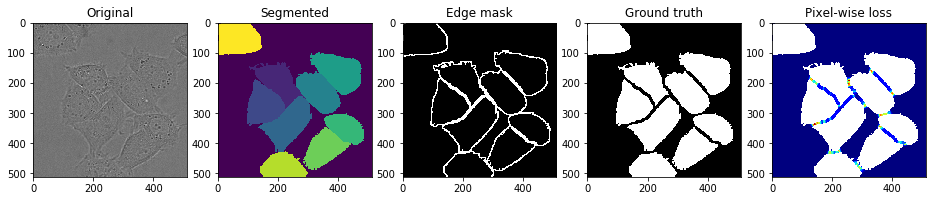

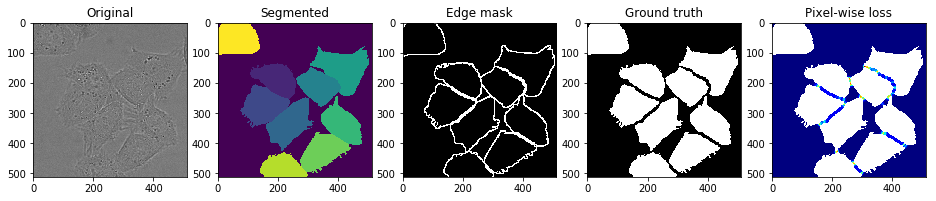

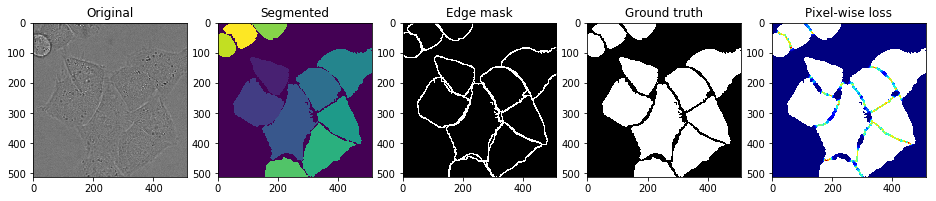

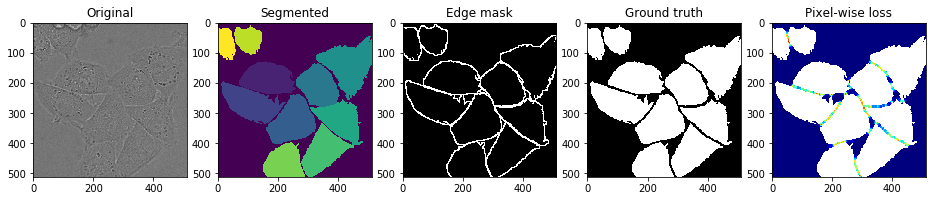

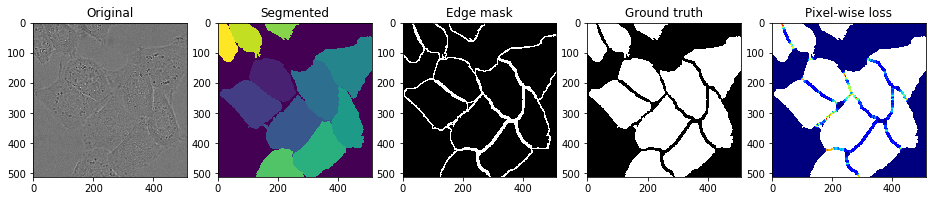

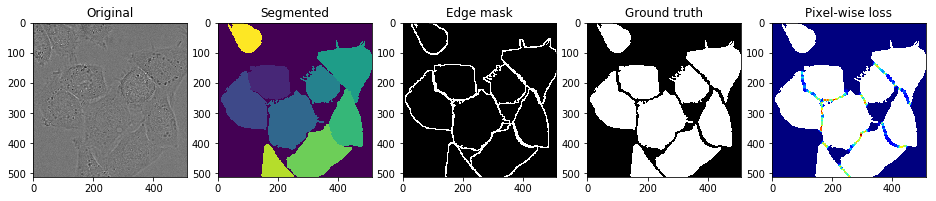

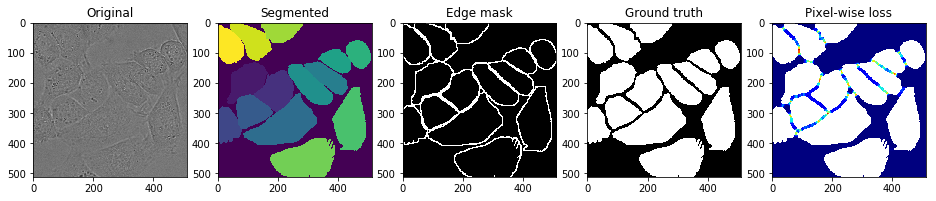

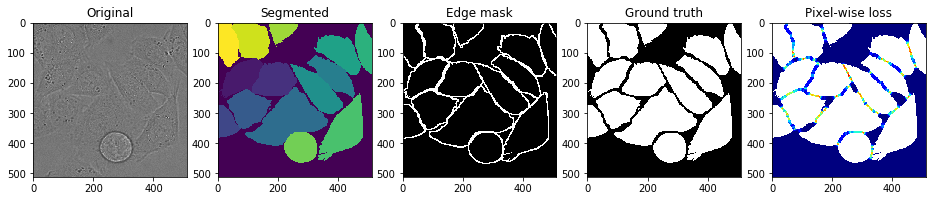

In [34]:
def preprocess_gt(img):
    kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
    mask_global = np.zeros(img.shape)
    for cls in np.unique(img):
        if cls == 0:  # if not a background
            continue
        mask_cls = np.zeros(img.shape)
        mask_cls[img==cls] = 255  # binary image of cell
        dilated = cv.dilate(mask_cls, kernel, iterations=2)
        mask_global += dilated-mask_cls  # add edge to global mask
#         mask += cv.erode(dilated-thresh,kernel2,iterations=1) 
#         mask +=  cv.morphologyEx(dilated-thresh, cv.MORPH_OPEN, kernel)
    
    gt = img - mask_global # edges of cells will be background on the new ground truth
    gt[gt<0] = 0  # clipping
    
    return gt, mask_global

# Download data
download_all_data()

# Specify which dataset to analyse
# DATASET = 'PhC-C2DH-U373'
DATASET = 'DIC-C2DH-HeLa'

target_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01_GT", "SEG")
training_path = os.path.join(CUR_DIR, "data", f"{DATASET}-training", "01")
target = os.listdir(target_path)
for i in range(len(target)):
    # load images
    img = cv.imread(os.path.join(target_path, target[i]), -1)
    img_og = cv.imread(os.path.join(training_path, f"t{target[i][7:]}"))
    
    # image morphology, for edge detection
    gt, mask_global = preprocess_gt(img)
    
    fig = plt.figure(figsize=(16,9))
    plt.subplot(1,5,1)
    plt.imshow(img_og)
    plt.title("Original")
    plt.subplot(1,5,2)
    plt.imshow(img)
    plt.title('Segmented')
    plt.subplot(1,5,3)
    plt.title('Edge mask')
    plt.imshow(mask_global > 0, cmap='gray')  # binary of cell edges
    plt.subplot(1,5,4)

    _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
    plt.imshow(gt_bin, cmap='gray')
    plt.title('Ground truth')
    
    # Calculating loss for ground truth
    wc = np.zeros(img.shape)
    for cls in np.unique(img):
        s = np.sum(img==cls)
        wc[gt==cls] = 1/s
    wc = wc / np.max(wc)  # normalize
    
    w0 = 10
    sigma = 5
    d1 = img.shape[0]*img.shape[1]*np.ones(img.shape)
    d2 = np.zeros(img.shape)

    dsts = []
    for cls in np.unique(img)[1:]:
        new_bin = np.zeros(img.shape)
        a = gt!=cls
        b = gt!=0
        new_bin[a & b] = 255
        gt_bin = 255-new_bin.astype(np.uint8)
        dst = cv.distanceTransform(src=gt_bin, distanceType=cv.DIST_L2, maskSize=3)
        d1 = np.minimum(d1, dst)
        d2 = np.maximum(d2, dst)
    
    loss_img = wc + w0*np.exp(-(d1+d2)**2 / (2*sigma**2))
    loss_img[gt > 0] = np.nan  # cells dont have loss (or loss=0?)
    
    plt.subplot(1,5,5)
    plt.imshow(loss_img, cmap='jet')
    
    plt.title("Pixel-wise loss")
    plt.show()

# Data Augmentation

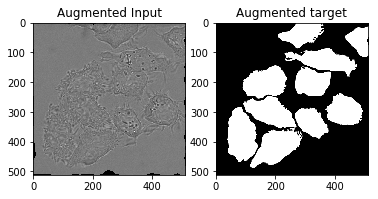

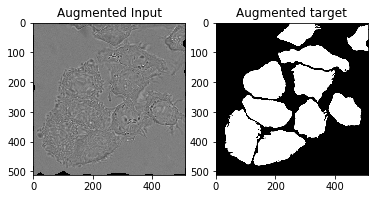

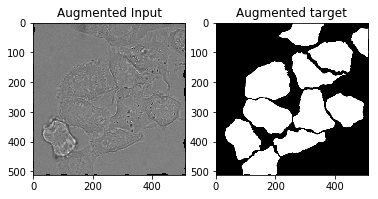

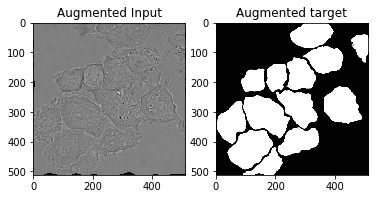

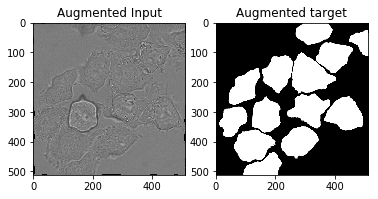

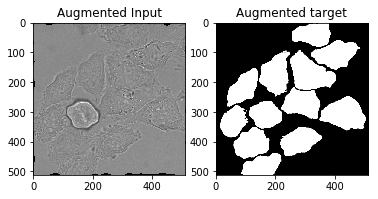

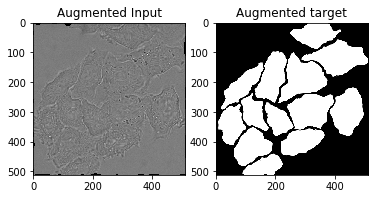

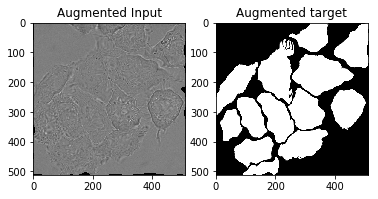

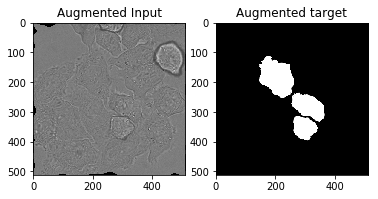

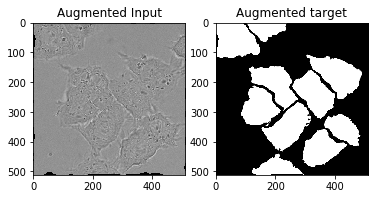

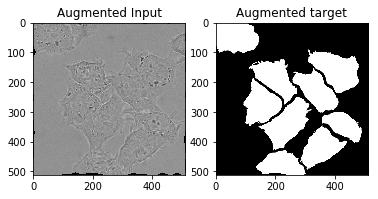

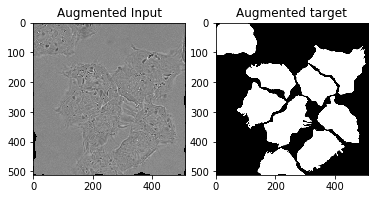

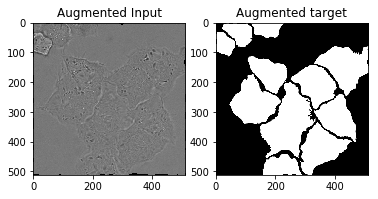

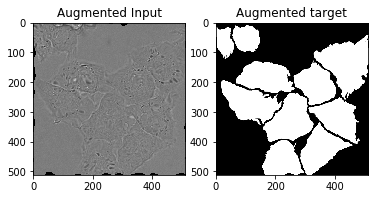

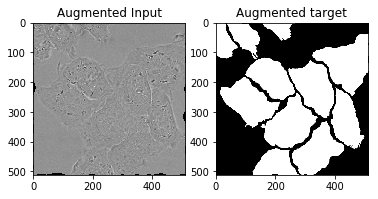

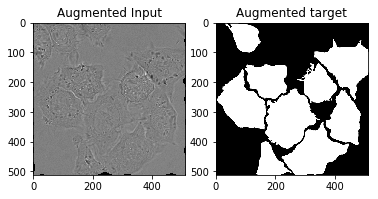

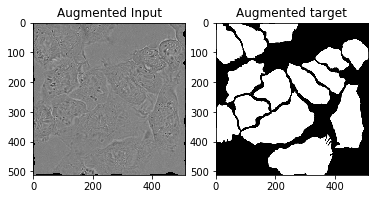

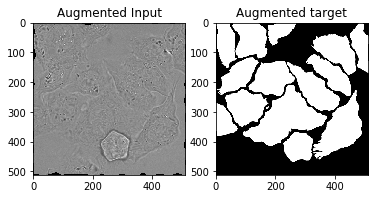

In [52]:
def elastic_transform(images, alpha, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       source: https://gist.github.com/chsasank/4d8f68caf01f041a6453e67fb30f8f5a
    """

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = images[0].shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    # TODO: change to bicubic interpolation
    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))
        
    return (map_coordinates(image, indices, order=1).reshape(shape) for image in images)


class ImageDataset(Dataset):
    def __init__(self, root_dir, alpha=3, sigma=10):
        self.root_dir = root_dir
        self.alpha = alpha
        self.sigma = sigma

        self.image = []
        self.target = []

        n = len(os.listdir(root_dir)) // 3
        for i in range(1, n+1):
            image_folder = os.path.join(root_dir, f"0{i}")
            target_folder = os.path.join(os.path.join(root_dir, f"0{i}_GT", "SEG"))
            image_names = [filename.replace('man_seg', 't') for filename in os.listdir(target_folder)]
            self.image.extend(cv.imread(os.path.join(image_folder, image_name), -1) for image_name in image_names)
            
            for filename in os.listdir(target_folder):
                img = cv.imread(os.path.join(target_folder, filename), -1)
                gt, _ = preprocess_gt(img)
                _, gt_bin = cv.threshold(gt, 0, 255, cv.THRESH_BINARY)
                self.target.append(gt_bin)

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        inp, gt = elastic_transform((self.image[idx], self.target[idx]), alpha=self.alpha, sigma=self.sigma)
        return transforms.ToTensor()(inp), \
               transforms.ToTensor()(gt)


# init ImageDataset
root_dir = os.path.join(CUR_DIR, "data", "DIC-C2DH-HeLa-training")
transformed_dataset = ImageDataset(root_dir, alpha=250, sigma=10)

# visualise augmentation
for i in range(len(image_dataset)):
    img, gt = transformed_dataset[i]
    plt.subplot(1,2,1)
    plt.imshow(img.reshape(img.shape[1:]), cmap='gray')
    plt.title("Augmented Input")
    plt.subplot(1,2,2)
    plt.imshow(gt.reshape(img.shape[1:]), cmap='gray')
    plt.title("Augmented Target")
    plt.show()

# init DataLoader
data_loader = DataLoader(transformed_dataset, batch_size=4, shuffle=True, num_workers=4)